# 1 hidden layer, varying width

In [163]:
import tensorflow as tf
tf.keras.backend.set_floatx('float64')
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from collections import defaultdict
from scipy.stats import entropy
from scipy.spatial.distance import pdist, squareform
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')

import sys
sys.path.append('../functions/')
from dataset import generate_gaussian_parity

In [190]:
# Polytope functions, tensorflow version
def get_polytopes(model, X, penultimate=False):
    """
    Description
    -----------
    From a ReLU neural network and a training dataset, computes the number of polytopes
    occupied by the training samples relative to the sample size. Each polytope
    corresponds to a fixed assignment of all ReLU's as either on/off and within each
    polytope the network is a linear function. One may think of this fraction
    as the relative number of piecewise linear functions a network has to learn on the
    data in order to perform well.
    
    Parameters
    ----------
    model : pytorch sequential network with ReLUs
    X : training data loader
    penultimate : boolean, default False
        If True, only returns polytopes using the last layer of ReLUs. Set to True
        if all the prior layers are viewed as a representation learner.
        
    Returns
    -------
    fraction : float
        Fraction of training samples in unique polytopes.
    polytope_assignments : list, length=dataloader_sample_size
        Labels encoding which samples occured in which polytopes.
    """
    polytope_memberships = []
    n_samples = 0
    
    n_samples += X.shape[0]
    polytope_memberships = []
    for layer in model.layers[:-1]: # Assumes sequential, may have to adjust based on model
        X = layer(X)
        binary_preactivation = (X.numpy() > 0.0).astype('int') * 2 - 1
        polytope_memberships.append(binary_preactivation)
    
    if penultimate:
        polytope_memberships = polytope_memberships[-1]
    else:
        polytope_memberships = np.hstack(polytope_memberships)
    
    polytopes, assignments, counts = np.unique(polytope_memberships, axis=0, return_inverse=True, return_counts=True)
    
    # kernel_mat = 1 - squareform(pdist(polytope_memberships, p=1)) / polytope_memberships.shape[1]
    # kernel_mat = polytope_memberships @ polytope_memberships.T / polytope_memberships.shape[1]
    # mat_evals = np.linalg.svd(kernel_mat, compute_uv=False, hermitian=True)
    mat_evals = np.linalg.svd(polytope_memberships / np.sqrt(polytope_memberships.shape[1]), compute_uv=False)**2
    
    return len(polytopes) / n_samples, assignments, counts, entropy(mat_evals)

In [191]:
# X_train, y_train = make_moons(1000)
X_train, y_train = generate_gaussian_parity(n=1000, angle_params=0, acorn=1234)
X_test, y_test = generate_gaussian_parity(n=10000, angle_params=0, acorn=66)

In [192]:
columns = [
    'width', 'rep', 'train_loss', 'train_acc', 'test_loss',
    'test_acc', 'saturation', 'internal_rep_entropy', 'df_kernel_entropy'
]
# results_mat = []
widths =  [2, 4, 6, 8, 10, 14, 20, 30, 40, 60, 100, 150, 200, 250, 300, 500, 1000]#, 1500, 2000]#, 40, 60, 80, 100]

for rep in range(1):
    for width in widths:
        model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(width, activation='relu'),
            tf.keras.layers.Dense(2)
        ])

        n_epochs = 20
        optimizer = tf.keras.optimizers.Adam(0.001)
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        metric = tf.keras.metrics.SparseCategoricalAccuracy()

        model.compile(
            optimizer=optimizer,
            loss=loss_fn,
            metrics=[metric],
        )

        history = model.fit(X_train, y_train, epochs=n_epochs, verbose=0)

        test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0) # Loss, accuracy
        train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0) # Loss, accuracy

        saturation, _, counts, kernel_entropy = get_polytopes(model, X_train)
        break
        eval_entropy = entropy(counts / sum(counts))

        results_mat += [[
            width, rep, train_loss, train_acc, test_loss, test_acc,
            saturation, eval_entropy, kernel_entropy
        ]]

results_df = pd.DataFrame(results_mat, columns=columns)

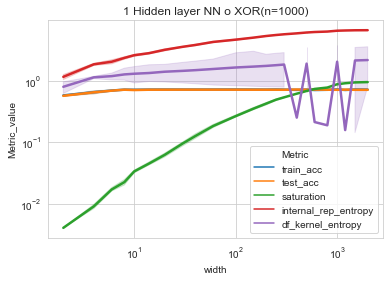

In [193]:
plot_df = results_df[
    ['width', 'rep', 'train_acc', 'test_acc', 'saturation', 'internal_rep_entropy', 'df_kernel_entropy']
].melt(id_vars = ['width', 'rep'], var_name='Metric', value_name='Metric_value')

sns.lineplot(
    data=plot_df,
    x='width',
    y='Metric_value',
    hue='Metric',
    palette="tab10", linewidth=2.5)

plt.xscale('log')
plt.yscale('log')
plt.title('1 Hidden layer NN o XOR(n=1000)')
plt.show()

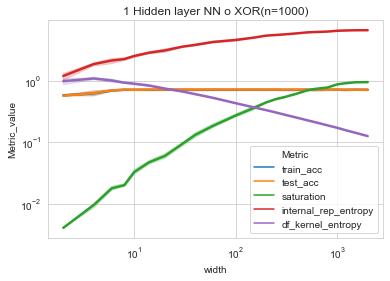

In [179]:
plot_df = results_df[
    ['width', 'rep', 'train_acc', 'test_acc', 'saturation', 'internal_rep_entropy', 'df_kernel_entropy']
].melt(id_vars = ['width', 'rep'], var_name='Metric', value_name='Metric_value')

sns.lineplot(
    data=plot_df,
    x='width',
    y='Metric_value',
    hue='Metric',
    palette="tab10", linewidth=2.5)

plt.xscale('log')
plt.yscale('log')
plt.title('1 Hidden layer NN o XOR(n=1000)')
plt.show()

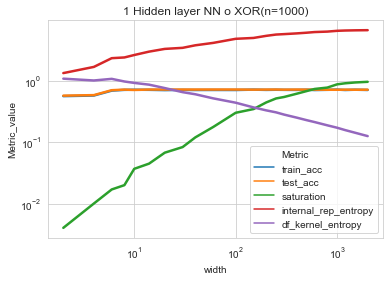

In [177]:
plot_df = results_df[
    ['width', 'rep', 'train_acc', 'test_acc', 'saturation', 'internal_rep_entropy', 'df_kernel_entropy']
].melt(id_vars = ['width', 'rep'], var_name='Metric', value_name='Metric_value')

sns.lineplot(
    data=plot_df,
    x='width',
    y='Metric_value',
    hue='Metric',
    palette="tab10", linewidth=2.5)

plt.xscale('log')
plt.yscale('log')
plt.title('1 Hidden layer NN o XOR(n=1000)')
plt.show()

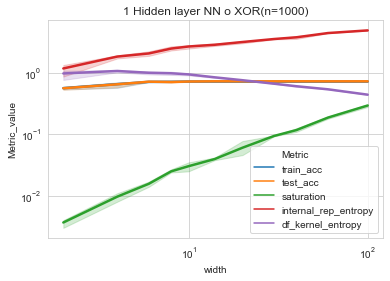

In [166]:
plot_df = results_df[
    ['width', 'rep', 'train_acc', 'test_acc', 'saturation', 'internal_rep_entropy', 'df_kernel_entropy']
].melt(id_vars = ['width', 'rep'], var_name='Metric', value_name='Metric_value')

sns.lineplot(
    data=plot_df,
    x='width',
    y='Metric_value',
    hue='Metric',
    palette="tab10", linewidth=2.5)

plt.xscale('log')
plt.yscale('log')
plt.title('1 Hidden layer NN o XOR(n=1000)')
plt.show()

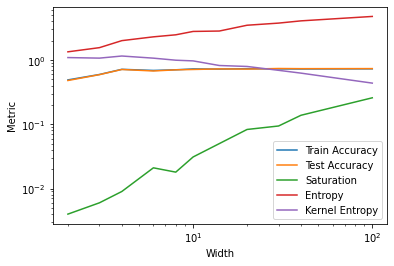

In [136]:
plt.plot(widths, np.asarray(results['train_acc']), label='Train Accuracy')
plt.plot(widths, np.asarray(results['test_acc']), label='Test Accuracy')
plt.plot(widths, results['sat'], label='Saturation')
plt.plot(widths, results['entropy'], label='Entropy')
plt.plot(widths, results['kernel_entropy'], label='Kernel Entropy')


plt.xlabel('Width')
plt.ylabel('Metric')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()

## Across epochs

In [94]:
results = defaultdict(list)
width = 10
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(width, activation='relu'),
    tf.keras.layers.Dense(2)
])

optimizer = tf.keras.optimizers.Adam(0.001)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy()

model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=[metric],
)

n_epochs = 40

for _ in range(n_epochs):
    history = model.fit(X_train, y_train, epochs=1, verbose=0)
    
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0) # Loss, accuracy
    train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0) # Loss, accuracy

    saturation, _ = get_polytopes(model, X_train)
    
    results['train_loss'].append(train_loss)
    results['train_acc'].append(train_acc)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_acc)
    results['sat'].append(saturation)

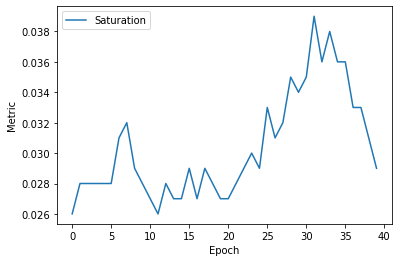

In [99]:
# plt.plot(list(range(n_epochs)), np.asarray(results['train_acc']) / max(results['train_acc']), label='Train Accuracy')
# plt.plot(list(range(n_epochs)), np.asarray(results['test_acc']) / max(results['test_acc']), label='Test Accuracy')
plt.plot(list(range(n_epochs)), results['sat'], label='Saturation')

plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
# plt.xscale('log')
# plt.yscale('log')
plt.show()